In [36]:
import os
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist

In [184]:
CUR_DIR = os.path.abspath('')

DATA_DIR = Path(CUR_DIR).parent / "data"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df_origin = pd.read_csv(FILE_PATH, index_col = 0)

In [39]:
'''
artist_names = df_origin['artist_name'].unique().tolist()
for artist_name in artist_names:
    mode_fam = df_origin[df_origin['artist_name'] == artist_name]['artist_familiarity'].mode()[0]
    mode_hot = df_origin[df_origin['artist_name'] == artist_name]['artist_hotttnesss'].mode()[0]
    
    df_origin.loc[df_origin['artist_name'] == artist_name, 'artist_familiarity'] = mode_fam
    df_origin.loc[df_origin['artist_name'] == artist_name, 'artist_hotttnesss'] = mode_hot
'''
    


In [185]:

df_unique_values = df_origin.drop_duplicates(subset = ['song_name', 'artist_name'], keep='first').reset_index().drop('index', axis=1)
tracks_quanti_feats = df_unique_values.drop(['user', 'listening_count', 'song_name', 'release', 'artist_name', 'valence',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key', 'duration',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)
       
'''
# valence?
df_unique_values = df_origin.drop_duplicates(subset = ['song_name', 'artist_name'], keep='first').reset_index().drop('index', axis=1)
tracks_quanti_feats = df_unique_values.drop(['user', 'listening_count', 'song_name', 'release', 'artist_name',
        'year', 'key', 'duration', 'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)
'''

"\n# valence?\ndf_unique_values = df_origin.drop_duplicates(subset = ['song_name', 'artist_name'], keep='first').reset_index().drop('index', axis=1)\ntracks_quanti_feats = df_unique_values.drop(['user', 'listening_count', 'song_name', 'release', 'artist_name',\n        'year', 'key', 'duration', 'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)\n"

In [186]:
scaler = StandardScaler()
scaler.fit(tracks_quanti_feats)
tracks_quanti_feats[tracks_quanti_feats.columns] = pd.DataFrame(scaler.fit_transform(tracks_quanti_feats), index=tracks_quanti_feats.index)

In [187]:
tracks_quanti_feats_names = pd.DataFrame(tracks_quanti_feats)
tracks_quanti_feats_names['song_name'] = df_unique_values['song_name']
tracks_quanti_feats_names['artist_name'] = df_unique_values['artist_name']


In [188]:

scaler = StandardScaler()
#sel_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
sel_columns = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']
df_origin[sel_columns] = pd.DataFrame(scaler.fit_transform(df_origin[sel_columns]), index=df_origin.index)

'''
scaler = StandardScaler()
sel_columns = ['artist_familiarity', 'artist_hotttnesss', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
df_origin[sel_columns] = pd.DataFrame(scaler.fit_transform(df_origin[sel_columns]), index=df_origin.index)
'''

"\nscaler = StandardScaler()\nsel_columns = ['artist_familiarity', 'artist_hotttnesss', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']\ndf_origin[sel_columns] = pd.DataFrame(scaler.fit_transform(df_origin[sel_columns]), index=df_origin.index)\n"

In [217]:
def get_opt_clusters(df:pd.DataFrame, drop : list[str], user_id: str):
    
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 
    

    # broad exploration of number of clusters
    dist = []
    s_scores = []
    range = np.arange(2,len(df_user)-1)
    for i in range:
        clf = KMeans(n_clusters = i, n_init = 'auto', random_state=123)
        clf.fit(df_user, sample_weight=user_listenings)
        centroids = clf.cluster_centers_
        labels = clf.labels_
        score = silhouette_score(df_user, labels, metric='euclidean')
        s_scores.append(score)
        dist.append(sum(np.min(cdist(XA = centroids, XB = df_user, metric='euclidean'), axis = 0)) / len(df_user))
    
    # optimal number of clusters selection by silhouette score
    n_clusters = s_scores.index(max(s_scores))+2

    return range, s_scores, dist, n_clusters

In [218]:
def get_user_profiles(df: pd.DataFrame, drop : list[str],  user_id: str, n_clusters:int):
    """
    Takes a user_id string and 1 dataframe containg all original informations and whose acoustic characteristics are Standard scaled.
    Returns the acoustic characteristics of the user standard profile weighted by number of listenings (1 acoustic profile)   
    and the cluster centers centroids profiles based on Kmeans fit on optimal number of cluster found per user (n_clusters profiles)

    Parameters:
        df : whole dataframe with all acoustic characteristics Standard scaled
        user_id : str corresponding to the user id
   
    Return :
        
        standard_profile: list[list[float]] of size 1
        cluster_profile: list[list[float]] of size n_clusters
    """
    
    
    total_listening = df[df["user"] == user_id]["listening_count"].sum() 

    ## Standard profile: one profile where acoustic characteristics are weighted by listening_count
    '''
    hotness = 0
    familiarity = 0
    '''
    duration = 0
    dance = 0
    energy = 0
    loudness = 0
    speech = 0
    acoustic = 0
    instru = 0
    live = 0
    valence = 0
    tempo = 0
    
    # cumulative sum of user's  songs acoustic characteristics weighted by listening_count
    for index, row, in df[df["user"] == user_id].iterrows():
        '''
        hotness += row['artist_hotttnesss'] * row["listening_count"]
        familiarity += row['artist_familiarity'] * row["listening_count"]   
        '''
        #duration += row['duration'] * row["listening_count"]
        dance += row['danceability'] * row["listening_count"]
        energy += row['energy'] * row["listening_count"]
        loudness += row['loudness'] * row["listening_count"]
        speech += row['speechiness'] * row["listening_count"]
        acoustic += row['acousticness'] * row["listening_count"]
        instru += row['instrumentalness'] * row["listening_count"]
        live += row['liveness'] * row["listening_count"]
        valence += row['valence'] * row["listening_count"]
        tempo += row['tempo'] * row["listening_count"]

    # duration / total_listening, 

    # weighted average from cumulative sum of acoustic characteristics / total_listening to list of lists
    # valence missing
    standard_profile = [[dance / total_listening, energy / total_listening,
                        loudness / total_listening, speech / total_listening, acoustic / total_listening,
                        instru / total_listening, live / total_listening, tempo / total_listening]]

    ## Cluster profile
    
    # definition of df_user
    df_user = df[df['user']==user_id].drop(drop, axis=1).reset_index().drop(['index'], axis=1)

    # weights to apply to the kmeans
    user_listenings = df_user['listening_count']

    # eliminate weights from acoustic characteristics
    df_user = df_user.drop('listening_count', axis=1) 

    # training of kmeans with optimal number of clusters
    clf = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state=123)
    clf.fit(df_user, sample_weight=user_listenings)
    centroids = clf.cluster_centers_
    labels = clf.labels_

    # distinct profiles as cluster centers centroids to list
    cluster_profile = centroids.tolist()

    
    return standard_profile, cluster_profile

Proximity measure - Numerical resolution

In [370]:
# var
#acoustic_variables = ["Artist Hotness", "Artist Familiarity", "Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "instrumentalness", "Liveness", "Valence", "Tempo"]
acoustic_variables = ["Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "instrumentalness", "Liveness", "Tempo"]
n_neighbors = 5000
#user_name = "ec6dfcf19485cb011e0b22637075037aae34cf26"
#user_name = '22e08d5e101ab5b86dc394856d508e175a5242a6'
user_name = '3fa44653315697f42410a30cb766a4eb102080bb'
#user_name = 'af3ee32357049dd96231238bd1b019e8142ee6aa' # l'espagnol

#user_name ='19a7ec5c51a370817f99cf18decde4b8f469bfd3'
#user_name ='19a7ec5c51a370817f99cf18decde4b8f469bfd3'


to_drop = ['user', 'song_name', 'release', 'artist_name', 'duration', 'artist_familiarity', 'artist_hotttnesss', 'valence',
           'year', 'shs_perf', 'shs_work', 'key', 'mode', 'explicit', 'time_signature', 'release_date']

'''
to_drop = ['user', 'song_name', 'release', 'artist_name', 'duration',  
           'year', 'shs_perf', 'shs_work', 'key', 'mode', 'explicit', 'time_signature', 'release_date']
'''

# func
range_n_clusters, silhouette_scores, distorsions, n_opt_cluster = get_opt_clusters(df=df_origin, drop=to_drop, user_id=user_name)

standard_profile, clusters_profiles = get_user_profiles(df=df_origin, drop=to_drop, user_id=user_name, n_clusters=n_opt_cluster)

C:\Users\benoit\AppData\Local\Temp\ipykernel_2408\1975603099.py:3: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



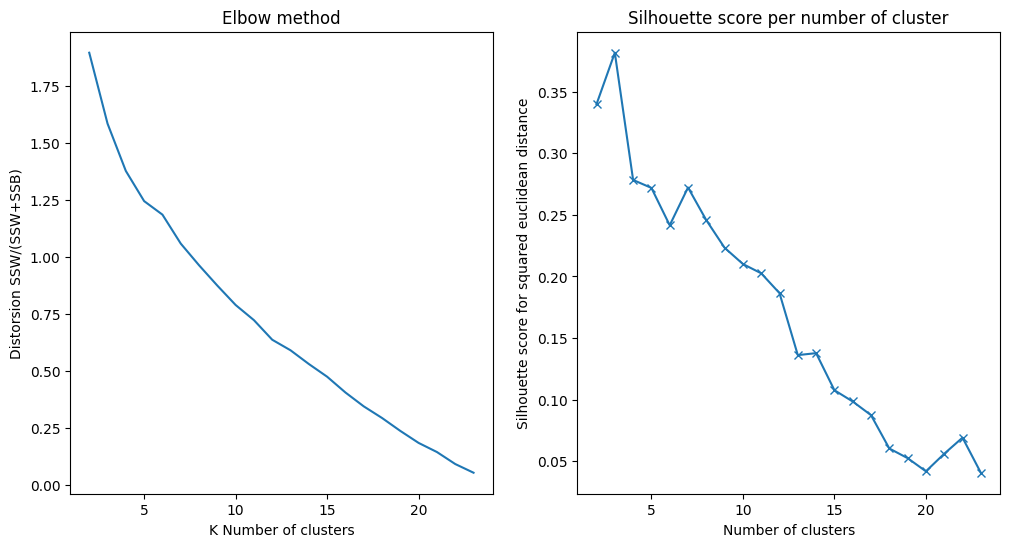

In [371]:
fig  = plt.subplots(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.plot(range_n_clusters, distorsions)
ax1.set_xlabel('K Number of clusters')
ax1.set_ylabel('Distorsion SSW/(SSW+SSB)')
ax1.set_title('Elbow method');

ax2 = plt.subplot(122)
ax2.plot(range_n_clusters, silhouette_scores, '-x')
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette score for squared euclidean distance")
ax2.set_title('Silhouette score per number of cluster');

In [372]:
from scipy.spatial import distance_matrix

def get_profile_neighbors(df_features, df_features_names: pd.DataFrame, profiles: list[list[float]], n_target : int = n_neighbors):
    
    '''
    user_profile = pd.DataFrame(columns=["hotness", "familiarity","danceability", "energy",
                                   "loudness", "speechiness", "acousticness",
                                   "instrumentalness", "liveness", "valence",
                                   "tempo"])
    '''
    user_profile = pd.DataFrame(columns=["danceability", "energy",
                                   "loudness", "speechiness", "acousticness",
                                   "instrumentalness", "liveness", 
                                   "tempo"])

    # append profile to the dataframe user_profile
    for i in range(len(profiles)):
        user_profile.loc[len(user_profile)] = profiles[i]


    # compute the distance matrix between all user_profiles and all songs features
    dist_mat = pd.DataFrame(distance_matrix(user_profile, df_features).T)
    #dist_mat = dist_mat.rename(columns={0 : 'distance'})
    

    # create similarity and disimilarity lists
    sim = []
    dis = []
    sim_id = []
    dis_id =[]

    # broadcast distance of matrix[i] to df_features_names containing song and artist names and sort values by distance[i]
    for i in range(len(profiles)):
        df_feats_names = df_features_names
        df_feats_names[i] = dist_mat[i]
        df_feats_names = df_feats_names.sort_values(by=i, ascending=True).reset_index().drop(['index'], axis=1)
        
        # for each profile create temporary sim and disim lists
        s = []
        d = []
        s_id = []
        d_id = []

        ## append each profile list the profile closest and furthest n_neighbors tracks and corresponding song-artist names 
        for j in range (n_target):
            
            '''
            s.append(df_feats_names.iloc[j, :9].values.flatten().tolist())
            s_id.append(' - '.join((df_feats_names.iloc[j, 9:11])))
            
            d.append(df_feats_names.iloc[len(df_feats_names)-1-j, :9].values.flatten().tolist())
            d_id.append(' - '.join((df_feats_names.iloc[len(df_feats_names)-1-j, 9:11])))
            '''
            s.append(df_feats_names.iloc[j, :8].values.flatten().tolist())
            s_id.append(' - '.join((df_feats_names.iloc[j, 8:10])))
            
            d.append(df_feats_names.iloc[len(df_feats_names)-1-j, :8].values.flatten().tolist())
            d_id.append(' - '.join((df_feats_names.iloc[len(df_feats_names)-1-j, 8:10])))

            
        sim.append(s)
        sim_id.append(s_id)
        dis.append(d)
        dis_id.append(d_id)

    return sim, dis, sim_id, dis_id

In [373]:
#similar, disimilar, sim_names, dis_names = get_profile_neighbors(tracks_quanti_feats, tracks_quanti_feats_names, standard_profile)
similar, disimilar, sim_names, dis_names = get_profile_neighbors(tracks_quanti_feats, tracks_quanti_feats_names, clusters_profiles)

In [374]:
print("Number of clusers", len(similar))
print("Number of songs per cluster times number of cluster / nb of songs = proportion of songs of the database",  len(similar[0])* n_opt_cluster / 27607)
#print(similar[0])
#print(sim_names[0])
#print(dis_names[0])


3
0.5433404571304379


['Thinking About Tomorrow - Beth Orton',
 'Trip To Mexico - George Lopez',
 'Failed Christian - Nick Lowe',
 'Chicano Dudes - George Lopez',
 "Evita's Lullaby - Alejandro Escovedo",
 'The Ride (Skit) - Krizz Kaliko',
 'Silly Boy - BMX Bandits',
 'ER - George Lopez',
 "Please Don't Tell Me How The Story Ends - Kris Kristofferson",
 'Seat Belts - Brian Regan']


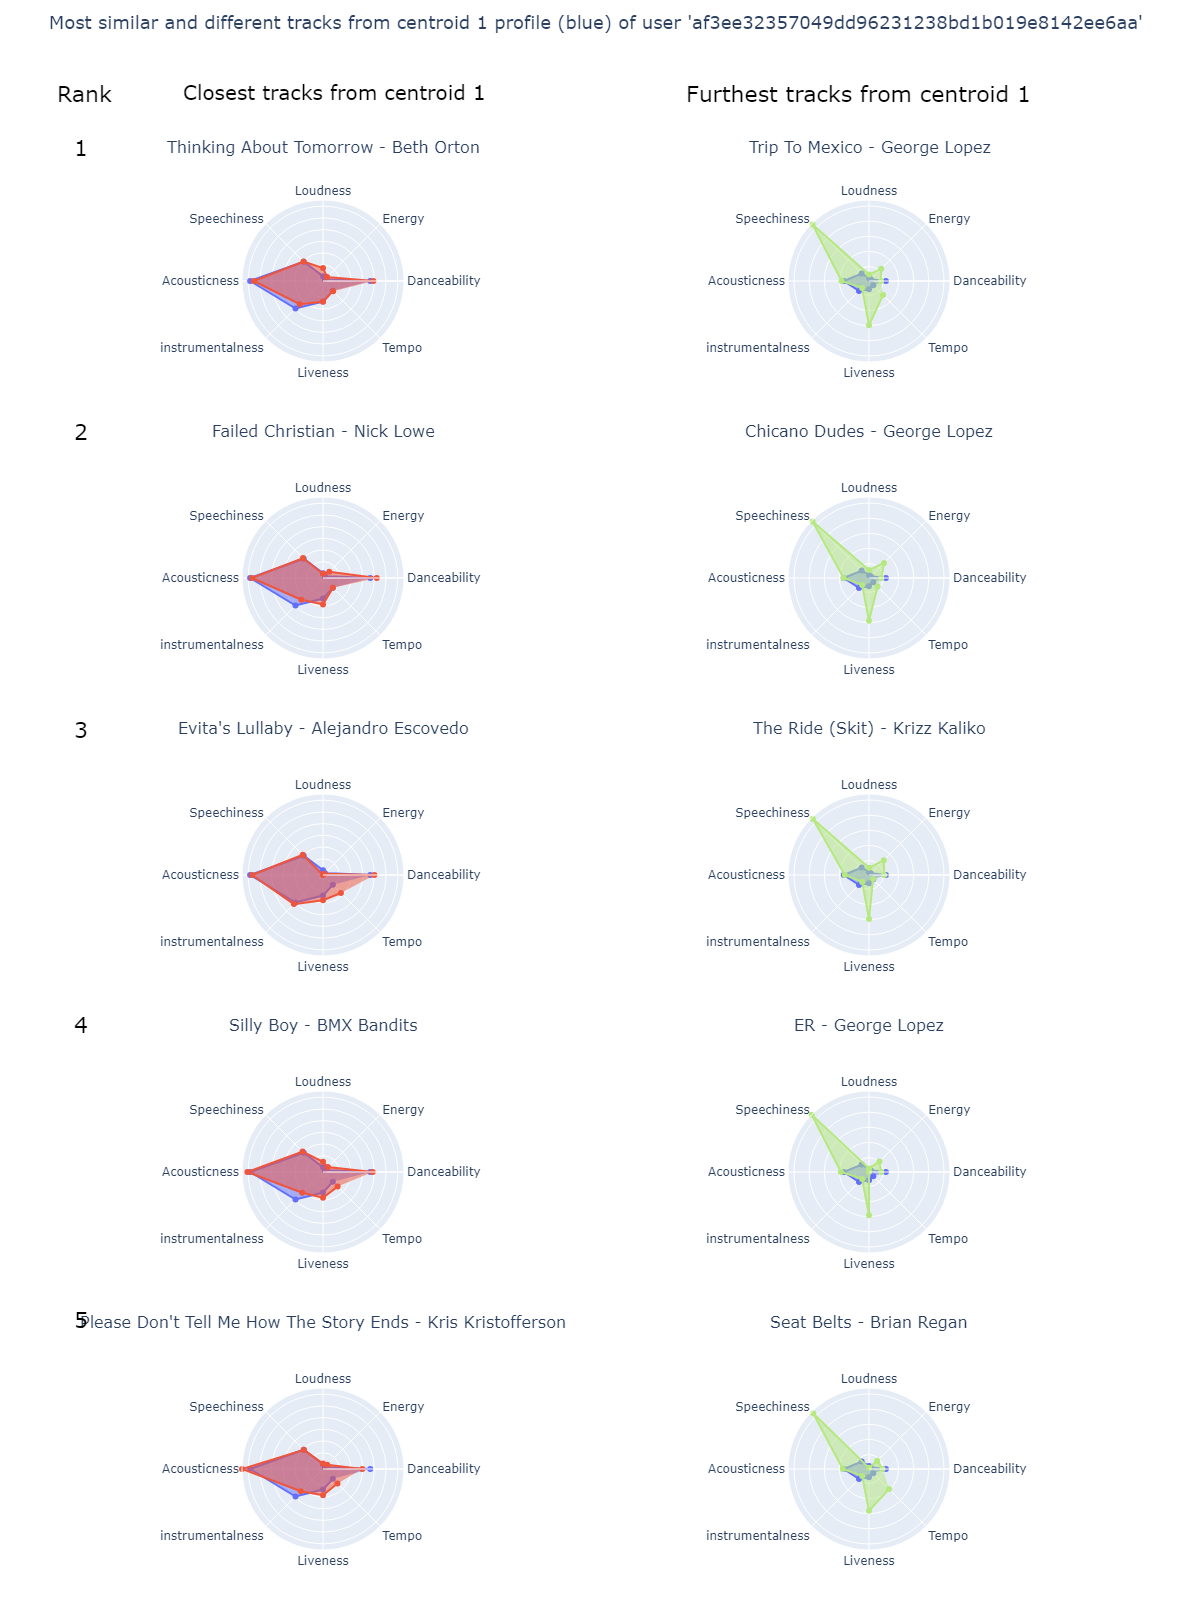

['La Estación - Mecano',
 '(Kanji) Ooioo - OOIOO',
 'Absolute Reality - The Alarm',
 'Introduction - Paul Horn',
 "Sweet Little Rock 'n' Roller - New Barbarians",
 'Rain - Shel Silverstein',
 'My Lullaby - Theatres Des Vampires',
 'Intro - Swell',
 'Conversations - Spyro Gyra',
 'Out Take 3 - Brad Paisley']


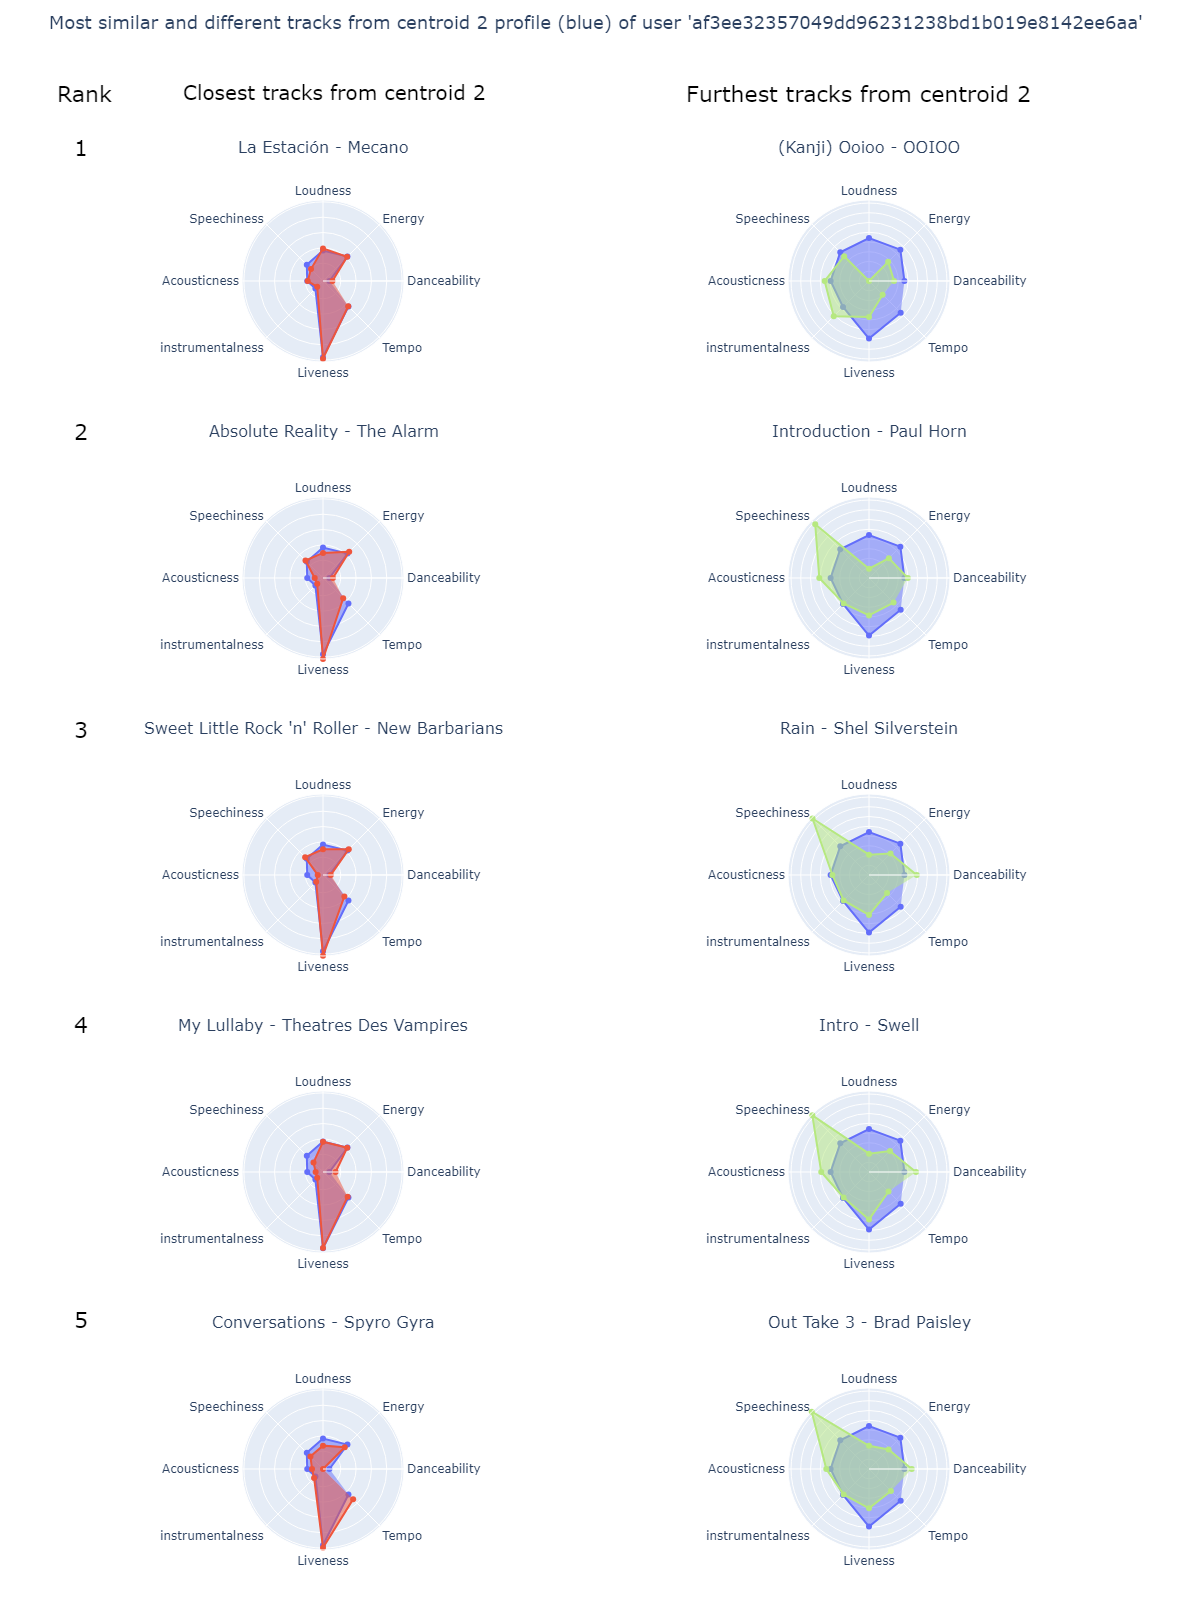

['Get Together Now Today - Buffalo Killers',
 'Intro - Swell',
 'A Beautiful Life - Lindsay Lohan',
 "Jaden's Interlude - Will Smith",
 'You Are - Tenth Avenue North',
 'Introduction - Paul Horn',
 'Chérie Lé - Vieux Farka Touré',
 '(Kanji) Ooioo - OOIOO',
 'Prisoners In Paradise (Single Edit) - Europe',
 'Socoro - George Lopez']


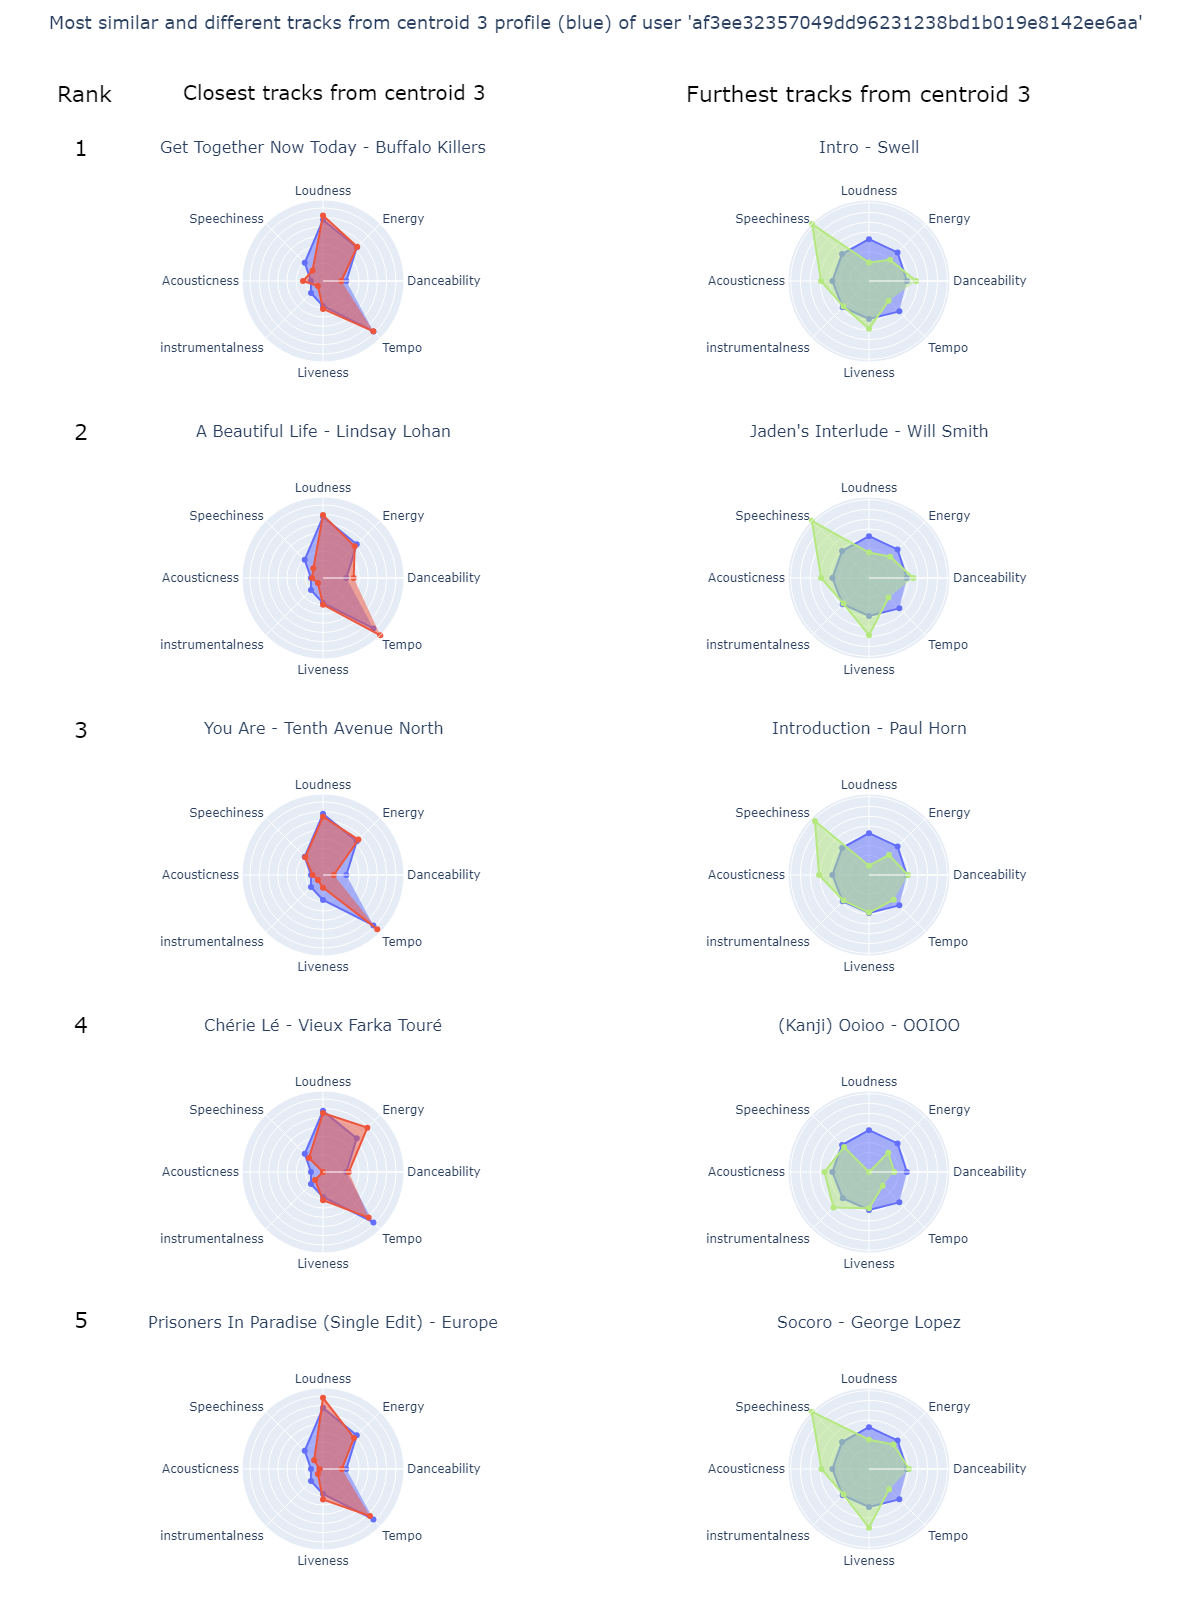

In [240]:
from pprint import pprint
import plotly.graph_objects as go
from plotly.subplots import make_subplots


for i in range(len(similar)):

    if (len(similar) == 1):
        profile = standard_profile
        std_prof = True
        prof_name = "Standard profile weighted by listening counts"
        fig_title = f"Most similar and different tracks from standard profile (blue) of user '{user_name}'"
        col1_title = "Closest tracks"
        col2_title = "Furthest tracks"

    elif (len(similar) > 1):
        profile = clusters_profiles    
        std_prof = False
        prof_name = f"Cluster center centroid {i+1} profile" 
        fig_title = f"Most similar and different tracks from centroid {i+1} profile (blue) of user '{user_name}'"
        col1_title = f"Closest tracks from centroid {i+1}"
        col2_title = f"Furthest tracks from centroid {i+1}"

    min_sim = np.min(similar[i])
    if min_sim > np.min(profile[i]):
        min_sim = np.min(profile[i])

    max_sim = np.max(similar[i])
    if max_sim < np.max(profile[i]):
        max_sim = np.max(profile[i])

    min_dis = np.min(disimilar[i])
    if min_dis > np.min(profile[i]):
        min_dis = np.min(profile[i])

    max_dis = np.max(disimilar[i])
    if max_dis < np.max(profile[i]):
        max_dis = np.max(profile[i])
    
    tracks_titles = []
    for j in range(len(similar[i])):
        tracks_titles.append(sim_names[i][j])
        tracks_titles.append(dis_names[i][j])



    fig = make_subplots(rows=n_neighbors, cols=2,
                        shared_xaxes='columns', shared_yaxes='columns',
                        vertical_spacing = 0.1,
                        horizontal_spacing=0,
                        #column_titles = ["Closest tracks", "Furthest tracks"],
                        #row_heights = [0.9,0.9],
                        subplot_titles=tracks_titles,
                     specs = [[{'type': 'polar'}]*2]*n_neighbors)


    trace_profile = go.Scatterpolar(r = profile[i],
                                             theta = acoustic_variables,
                                             mode = "lines+markers", line_color='#636EFA',
                                             
                                                                                          
                                             name = prof_name)

    #https://community.plotly.com/t/plotly-colours-list/11730/3
    #colors_col2 = ['orange', '#8c564b', '#7f7f7f', '#2ca02c', 'pink' ]
    

    for j in range(len(similar[i])):
        
        fig.add_trace(trace_profile, row=j+1, col=1)

        fig.add_trace(go.Scatterpolar(
            r = similar[i][j],
            name = f"Closest track rank {j+1}",
            theta = acoustic_variables,
            line_color = '#EF553B',
            #text=["Foundbird - Papercuts"],
            #textposition="top center"
        ),  row=j+1, col=1)

        fig.add_trace(trace_profile, row=j+1, col=2)

        fig.add_trace(go.Scatterpolar(
            r = disimilar[i][j],
            name = f"Furthest track rank {j+1}",
            theta = acoustic_variables,
            line_color = '#B6E880',  #colors_col2[j],
        ),  row=j+1, col=2)

    

    fig.update_traces(fill='toself')#,
                      #mode = "lines+markers", line_color='indianred',
                      #marker =   dict(color='lightslategray', size=8, symbol='square'))

    
    fig.update_layout(
        height = 1600,
        width = 1200,
        #title_text = "Test",
        title= dict(text=fig_title,
                    x=0.5,
                    y=0.99,
                    #x_anchor = 'center',
                    #y_anchor = 'top',
                    font = dict(
                        #family = 'Courier New')
                        size = 18)),
                    #margin=dict(l=50, r=50, t=200, b=50),
                    margin=dict(l=50, r=50, t=200, b=50),
        #paper_bgcolor="LightSteelBlue",
        polar = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]), #radialaxis_range = [-10,10]),
                     #angularaxis = dict(showticklabels=False, ticks='')
        polar2 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),
        
        polar3 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),

        polar4 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),

        polar5 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),

        polar6 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),

        polar7 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),

        polar8 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),

        polar9 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_sim,max_sim]),
        
        polar10 = dict(radialaxis = dict(showticklabels=False, ticks='' ), radialaxis_range = [min_dis,max_dis]),
                     
        showlegend=False
    )
    
    if len(similar) > 1:
        fig.add_annotation(x= 0.12, y = 1.09,
                           text = col1_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=20))
        fig.add_annotation(x= 0.9, y = 1.09,
                           text = col2_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    elif len(similar) == 1:
            fig.add_annotation(x= 0.19, y = 1.09,
                           text = col1_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
            fig.add_annotation(x= 0.81, y = 1.09,
                           text = col2_title,
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))

    fig.add_annotation(x= 0.005, y = 1.09,
                           text = "Rank",
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    fig.add_annotation(x= 0.02, y = 1.05,
                           text = '1',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.02, y = 0.84,
                           text = '2',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.02, y = 0.608,
                           text = '3',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.02, y = 0.389,
                           text = '4',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))
    
    fig.add_annotation(x= 0.02, y = 0.159,
                           text = '5',
                           showarrow=False,
                           font = dict(color="black",
                                       size=22))

    annot =list(fig.layout.annotations)
    annot[0].y = 1.03
    annot[1].y = 1.03
    annot[2].y = 0.82 
    annot[3].y = 0.82 
    annot[4].y = 0.6 
    annot[5].y = 0.6 
    annot[6].y = 0.38 
    annot[7].y = 0.38 
    annot[8].y = 0.16 
    annot[9].y = 0.16 

    fig.layout.annotations = annot

    #https://plotly.com/python/reference/layout/polar/
    fig.update_polars(
        radialaxis_showticklabels = False
    )
    
    pprint(tracks_titles)
    names = set()
    fig.for_each_trace(
        lambda trace:
            trace.update(showlegend=False)
            if (trace.name in names) else names.add(trace.name))

    fig.show()


In [375]:
song_user = (df_origin[df_origin["user"] == user_name]['song_name'] + ' - ' + df_origin[df_origin["user"] == user_name]['artist_name']).tolist()


song_reco = []
for i in range(len(sim_names)):
    song_reco.extend(sim_names[i])
#song_reco    
print(len([i for i in song_user if i in song_reco]))
[i for i in song_user if i in song_reco]

20


['Marry Me - Train',
 'Almaz - Randy Crawford',
 'Home - Daughtry',
 "California Dreamin' - The Mamas & The Papas",
 'Fortunate Son - Creedence Clearwater Revival',
 'Love Song - Sara Bareilles',
 'Bleeding Love - Leona Lewis',
 'Torn - Natalie Imbruglia',
 'Girls Just Want To Have Fun - Cyndi Lauper',
 'Breakdown - Daughtry',
 'Gravity - John Mayer',
 'Hey Jealousy - Gin Blossoms',
 'Caught Up In You - 38 Special',
 'More Than A Feeling - Boston',
 'Calling All Angels - Train',
 'Allison Road - Gin Blossoms',
 "I'll Be - Edwin McCain",
 'Lucky Boy - Matt Nathanson',
 'Life Less Ordinary - Carbon Leaf',
 'Mandolin Moon - Sister Hazel']

In [376]:
song_list = [i.split(' - ', 1)[0] for i in song_reco]
pprint(song_list)
artist_list = [i.split(' - ', 1)[1] for i in song_reco]
pprint(artist_list)

['Ciuin An Oidhach (Silent Night)',
 'The Song Of Wandering Aengus',
 'Dark as a Dungeon',
 'The Lass of Glenshee',
 'Soon As My Heart Breaks',
 'Vanished Like the Show',
 'Yes',
 'Even So',
 'When He Returns',
 'Love For Sale',
 'Tender Years',
 'It Never Entered My Mind',
 'Skinny Leg Blues',
 'Body and Soul',
 'Hanna',
 'Coming of the Roads',
 'Desperate For Love',
 'Lime Tree',
 'Blue Angel',
 'Streets Of Laredo',
 'Think Of Rain',
 "Master's House",
 'The Unquiet Grave',
 'N.Y.',
 "I'll Find a Way",
 'A Long Time',
 'The Man I Love',
 'Mal de mer',
 'Basement Home',
 'Ae Fond Kiss',
 'Talvipuutarhaan',
 "No Man's Land",
 'Oh Death',
 'The Grey Selchie',
 'This Is What',
 'Sitting On Top Of The World',
 'Ancestors',
 'Reassemble',
 'Meadowlarks',
 'You You You You You',
 'If You Were Here',
 'Feel To Believe',
 'A Faceless Death',
 'This Time Of The Year',
 'The Luckiest',
 "'Round Midnight",
 'Too Late To Cry',
 'Siligugu Isiphambano',
 'The First Time',
 'Enjoy Your Day',
 'Cross

In [377]:
df_user_temp = df_origin[df_origin["user"] == user_name]
import dataframe_image as dfi 
'''
def highlight_interest(val):
    
    is_present = [i for i in song_user if i in song_reco]
    color = 'red' if val in is_present else 'black'
    
    return 'color: %s' % color
    #return ['background-color: blue' if i in is_present else 'background-color: white'] 

df_user_temp.style.apply(highlight_interest)
'''
def red_or_auto(x):
    # set font color to red for keys whose corresponding v is positive
    # all other values have default font color
    #return pd.DataFrame('', index=x.index, columns=x.columns).assign(song_name=np.where(x['song_name'] + ' - ' + x['artist_name'].isin(song_reco), "color:red", ''))
    return pd.DataFrame('', index=x.index, columns=x.columns).assign(song_name=np.where((x['song_name'].isin(song_list)) & (x['artist_name'].isin(artist_list)) , "color:red", ''),
                                                                     artist_name = (np.where((x['artist_name'].isin(artist_list)) & (x['song_name'].isin(song_list)), "color:red", '')))

df_styled = df_user_temp.style.apply(red_or_auto, axis=None, subset=['song_name', 'artist_name'])
df_styled


#dfi.export(df_styled, 'df_classic.png')
#dfi.export(df_styled, 'df_espagnol.png')

,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,shs_work,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date
136725,3fa44653315697f42410a30cb766a4eb102080bb,76,Marry Me,Save Me_ San Francisco,Train,205.452610,0.838886,0.783677,2009,-1,0,False,-0.186446,-1.669128,0,-0.287864,1,-0.524686,1.953590,-0.455750,-0.587886,0.480000,-1.090074,4.000000,2018-11-09
363469,3fa44653315697f42410a30cb766a4eb102080bb,30,Almaz,Every Kind Of Mood,Randy Crawford,270.758730,0.625343,0.412424,1986,-1,0,False,-1.374965,-2.166352,2,-1.513655,0,-0.490846,2.217383,-0.455790,0.450353,0.242000,0.626407,4.000000,2019-02-15
367103,3fa44653315697f42410a30cb766a4eb102080bb,16,Home,Daughtry (Deluxe Edition),Daughtry,255.659950,0.834295,0.678824,2006,-1,0,False,-0.538151,0.872244,6,1.152727,1,-0.436183,-0.825799,-0.455814,-0.101211,0.336000,0.778201,4.000000,2006-11-20
544892,3fa44653315697f42410a30cb766a4eb102080bb,93,Float On,Float On,Modest Mouse,209.527710,0.808802,0.613120,2003,-1,0,False,0.668560,1.037985,6,0.911631,1,-0.502560,-0.789857,-0.455811,-0.675487,0.553000,-0.694417,4.000000,2004-04-05
709728,3fa44653315697f42410a30cb766a4eb102080bb,216,California Dreamin',The Best Sixties Album In The World...Ever!,The Mamas & The Papas,157.700770,0.680549,0.502711,1965,-1,0,False,-0.241021,-0.300697,1,-0.266253,0,-0.168070,0.120229,-0.455820,1.234440,0.602000,-0.194237,4.000000,2017-06-09
971637,3fa44653315697f42410a30cb766a4eb102080bb,17,Fortunate Son,More Creedence Gold,Creedence Clearwater Revival,138.370160,0.630471,0.501856,1969,-1,0,False,0.644304,0.179529,0,0.277646,1,-0.308634,-0.371086,-0.418882,0.417908,0.650000,0.389130,4.000000,2001-10-02
1209143,3fa44653315697f42410a30cb766a4eb102080bb,82,Love Song,Little Voice,Sara Bareilles,260.832200,0.782098,0.728923,2007,-1,0,False,0.268344,0.604507,2,1.345136,0,-0.492148,-0.764137,-0.455820,-0.139064,0.573000,0.063006,4.000000,2007-07-03
1314487,3fa44653315697f42410a30cb766a4eb102080bb,82,Unwritten,Divas Collection,Natasha Bedingfield,259.343220,0.900968,0.769674,2004,-1,0,False,1.311330,0.655505,7,0.665848,0,-0.191497,-0.819369,-0.455820,-0.922069,0.754000,-0.728343,4.000000,2007-02-13
1320124,3fa44653315697f42410a30cb766a4eb102080bb,74,Bleeding Love,Spirit,Leona Lewis,262.477910,0.917255,0.602637,2007,-1,0,False,0.583666,-0.024461,5,0.616899,1,-0.399740,-0.199620,-0.455820,-0.376994,0.217000,-0.589928,4.000000,2007
1352821,3fa44653315697f42410a30cb766a4eb102080bb,77,Boys Don't Cry,Starter For 10: Original Motion Picture Soundtrack [International],The Cure,161.488530,0.811953,0.592381,1979,-1,41688,False,-0.459321,0.889243,11,0.538530,0,0.036269,-0.799419,-0.455820,-0.577071,0.690000,1.658773,4.000000,2020-02-28
